In [ ]:
# 📦 Install missing packages in Google Colab
!pip install -q seaborn xgboost scikit-learn joblib

In [ ]:
# 📚 Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from joblib import dump

In [ ]:

from google.colab import files
uploaded = files.upload()
df = pd.read_excel('flood dataset.xlsx')
print(df.head())


Saving flood dataset.xlsx to flood dataset.xlsx
   Temp  Humidity  Cloud Cover  ANNUAL  Jan-Feb  Mar-May  Jun-Sep  Oct-Dec  \
0    29        70           30  3248.6     73.4    386.2   2122.8    666.1   
1    28        75           40  3326.6      9.3    275.7   2403.4    638.2   
2    28        75           42  3271.2     21.7    336.3   2343.0    570.1   
3    29        71           44  3129.7     26.7    339.4   2398.2    365.3   
4    31        74           40  2741.6     23.4    378.5   1881.5    458.1   

      avgjune    sub  flood  
0  274.866667  649.9      0  
1  130.300000  256.4      1  
2  186.200000  308.9      0  
3  366.066667  862.5      0  
4  283.400000  586.9      0  


In [ ]:
### 📊 Univariate Analysis (Numerical & Categorical)
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()

if 'flood' in df.columns:
    categorical_cols.append('flood')
    if 'flood' in numerical_cols:
        numerical_cols.remove('flood')

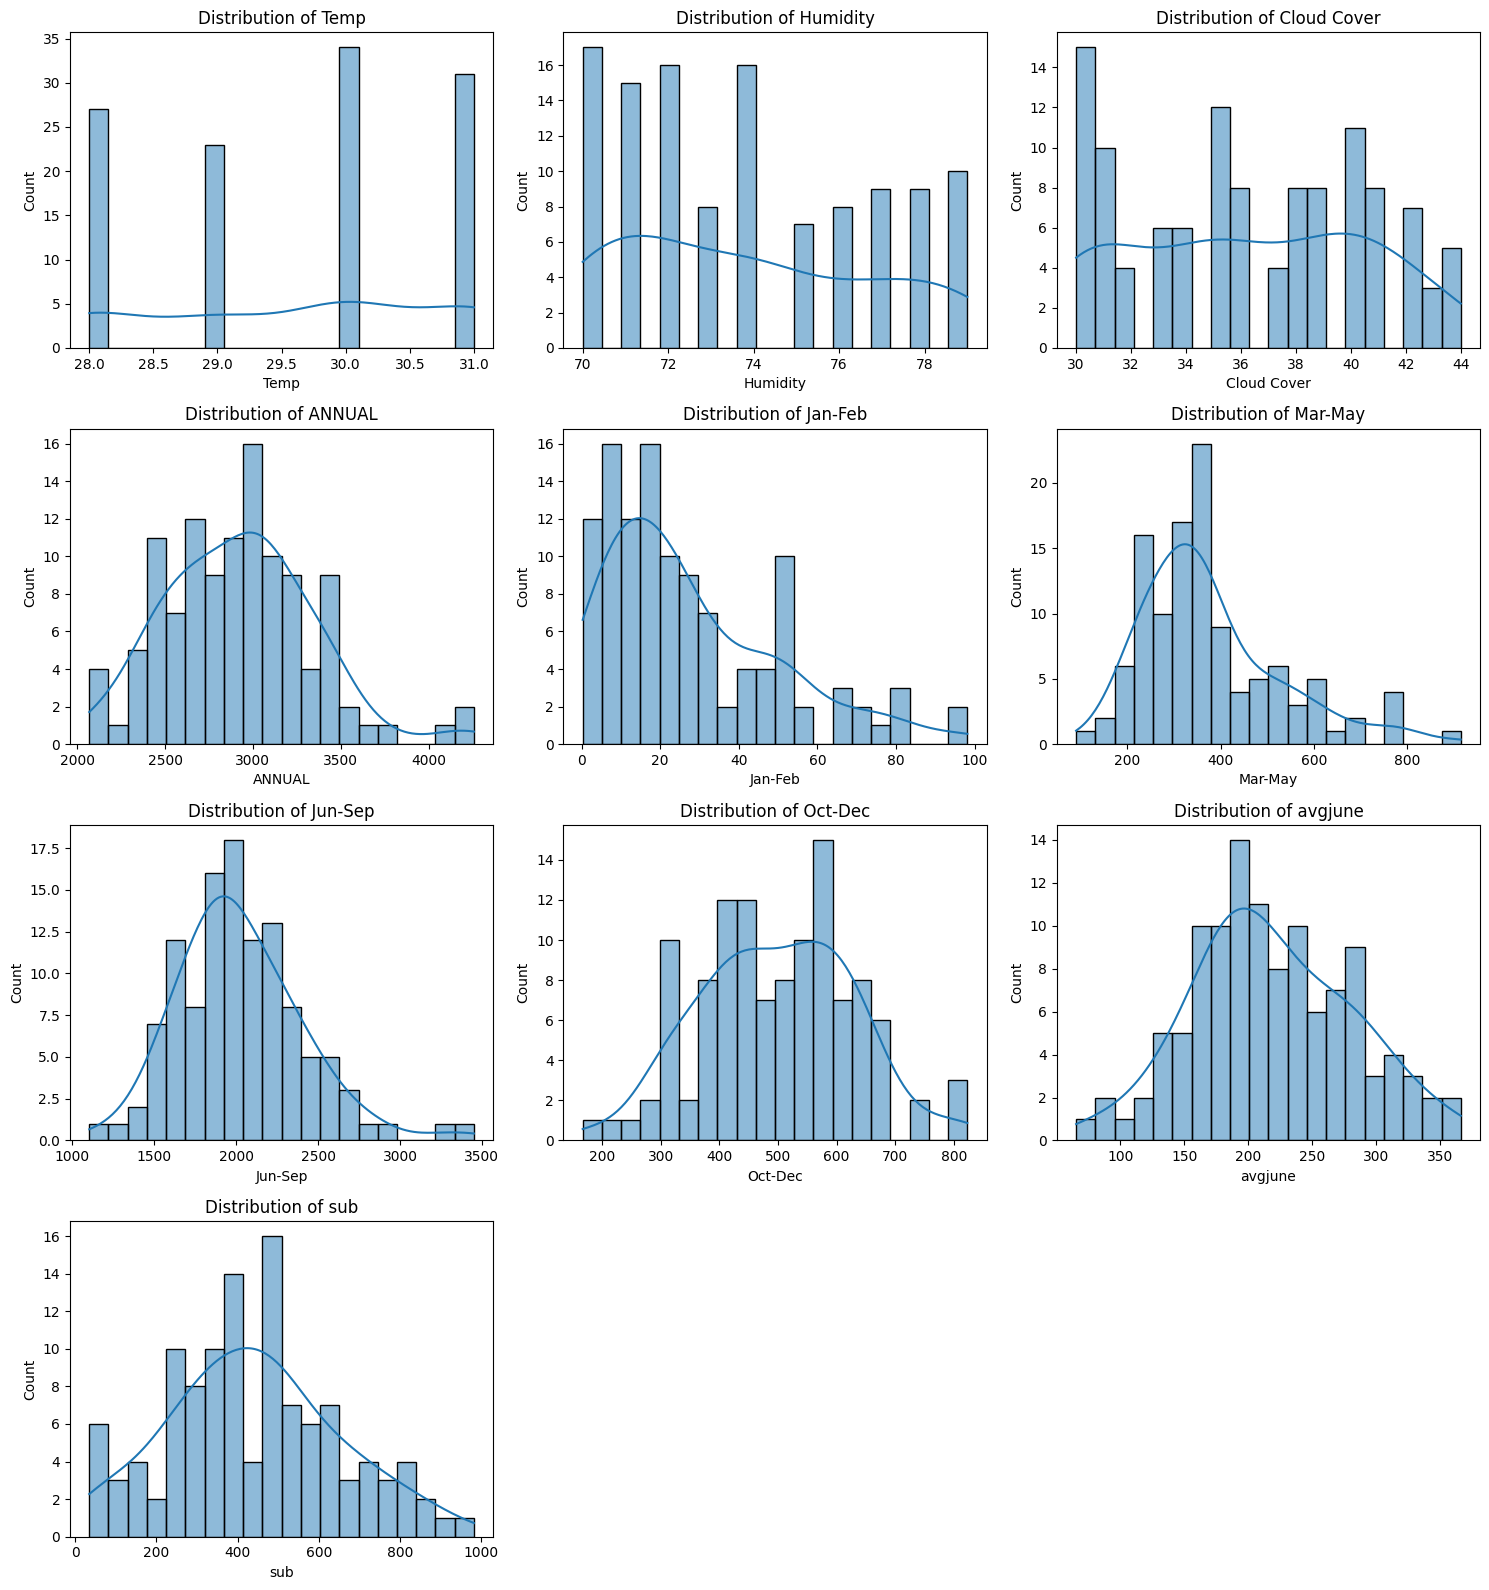

In [ ]:
# Numerical histograms
cols = 3
rows = (len(numerical_cols) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
axes = axes.flatten()
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=20)
    axes[i].set_title(f"Distribution of {col}")
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

/tmp/ipython-input-9-4153350653.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='Set2')


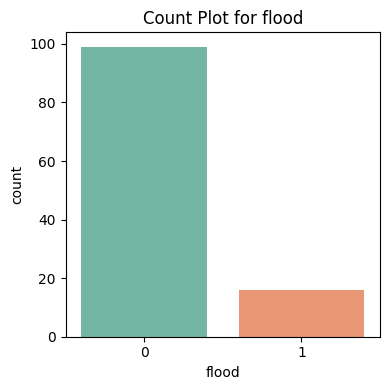

In [ ]:
# Categorical count plots
for col in categorical_cols:
    plt.figure(figsize=(4, 4))
    sns.countplot(x=col, data=df, palette='Set2')
    plt.title(f"Count Plot for {col}")
    plt.tight_layout()
    plt.show()

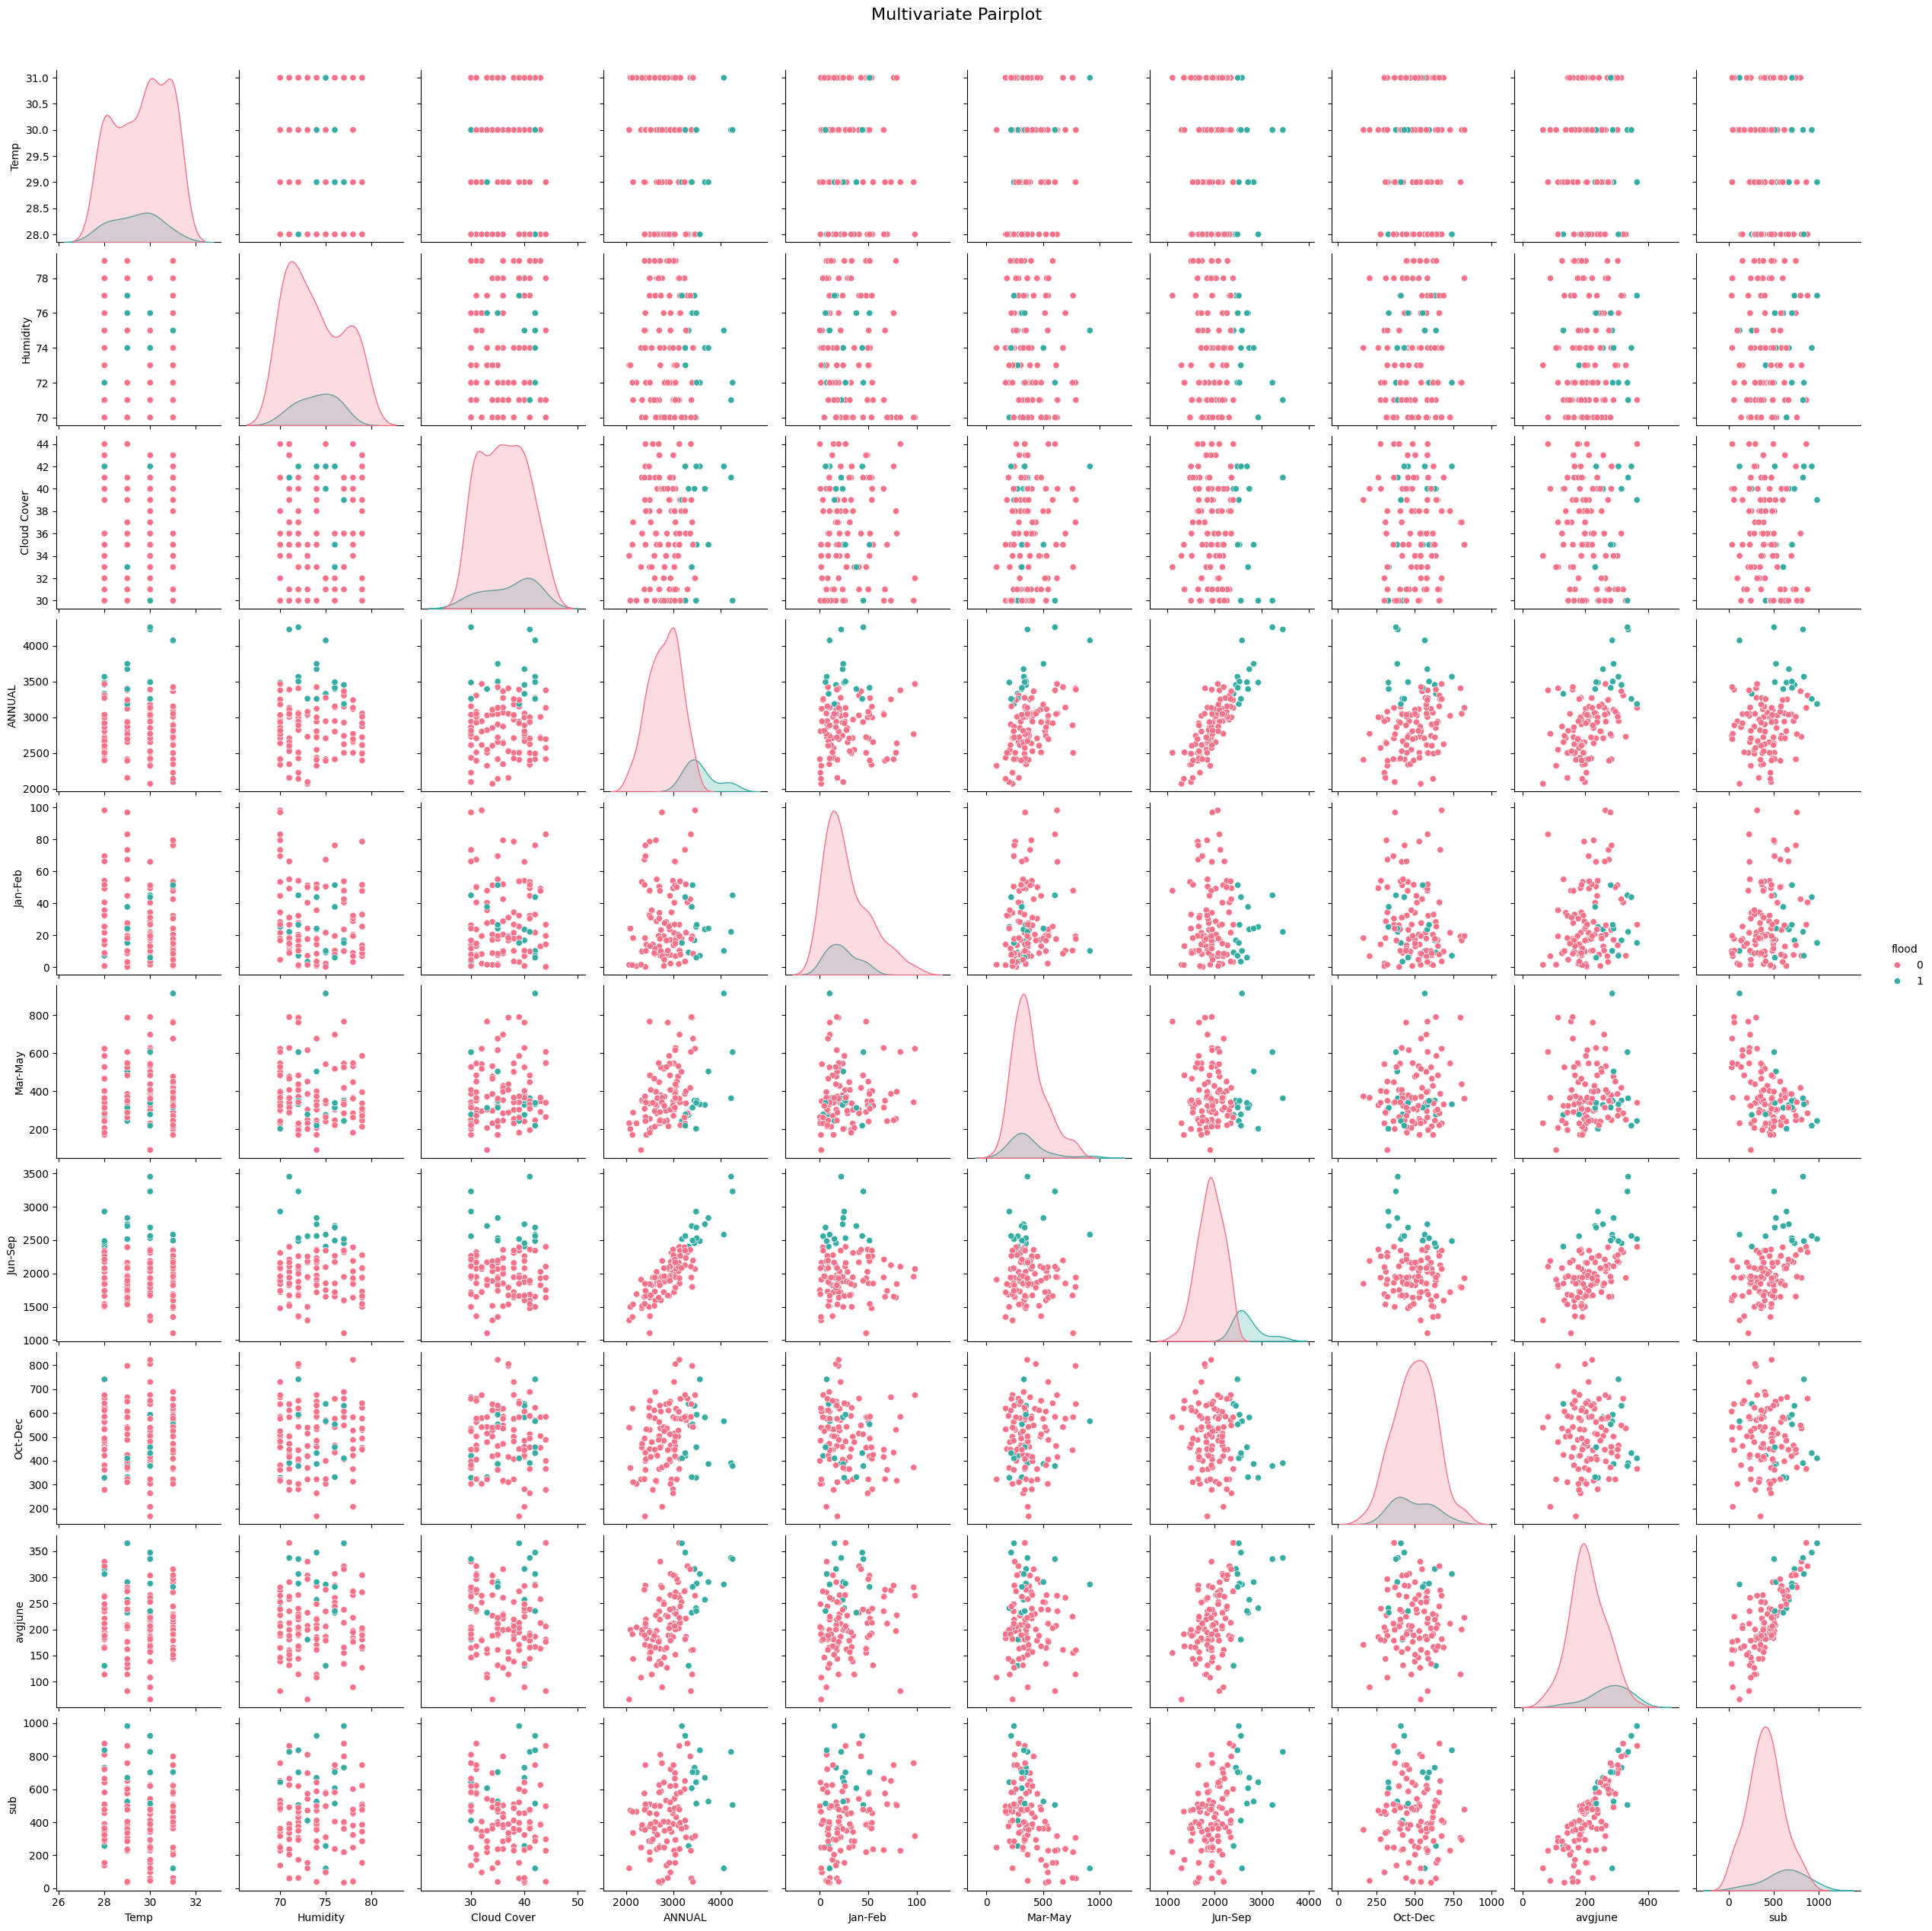

In [ ]:
### 🔗 Multivariate Analysis
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'flood' not in numerical_cols and 'flood' in df.columns:
    numerical_cols.append('flood')

sns.pairplot(df[numerical_cols], hue='flood', diag_kind='kde', palette='husl')
plt.suptitle("Multivariate Pairplot", fontsize=16, y=1.02)
plt.show()


In [ ]:
### 📈 Descriptive Statistics & Missing Values
print(df.describe())
print(df.isnull().sum())

             Temp    Humidity  Cloud Cover       ANNUAL     Jan-Feb  \
count  115.000000  115.000000   115.000000   115.000000  115.000000   
mean    29.600000   73.852174    36.286957  2925.487826   27.739130   
std      1.122341    2.947623     4.330158   422.112193   22.361032   
min     28.000000   70.000000    30.000000  2068.800000    0.300000   
25%     29.000000   71.000000    32.500000  2627.900000   10.250000   
50%     30.000000   74.000000    36.000000  2937.500000   20.500000   
75%     31.000000   76.000000    40.000000  3164.100000   41.600000   
max     31.000000   79.000000    44.000000  4257.800000   98.100000   

          Mar-May      Jun-Sep     Oct-Dec     avgjune         sub       flood  
count  115.000000   115.000000  115.000000  115.000000  115.000000  115.000000  
mean   377.253913  2022.840870  497.636522  218.100870  439.801739    0.139130  
std    151.091850   386.254397  129.860643   62.547597  210.438813    0.347597  
min     89.900000  1104.300000  166.

In [ ]:
### 🚨 Outlier Detection & Removal (IQR Method)
def remove_outliers_IQR(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'flood' in numerical_cols:
    numerical_cols.remove('flood')

for col in numerical_cols:
    df = remove_outliers_IQR(df, col)


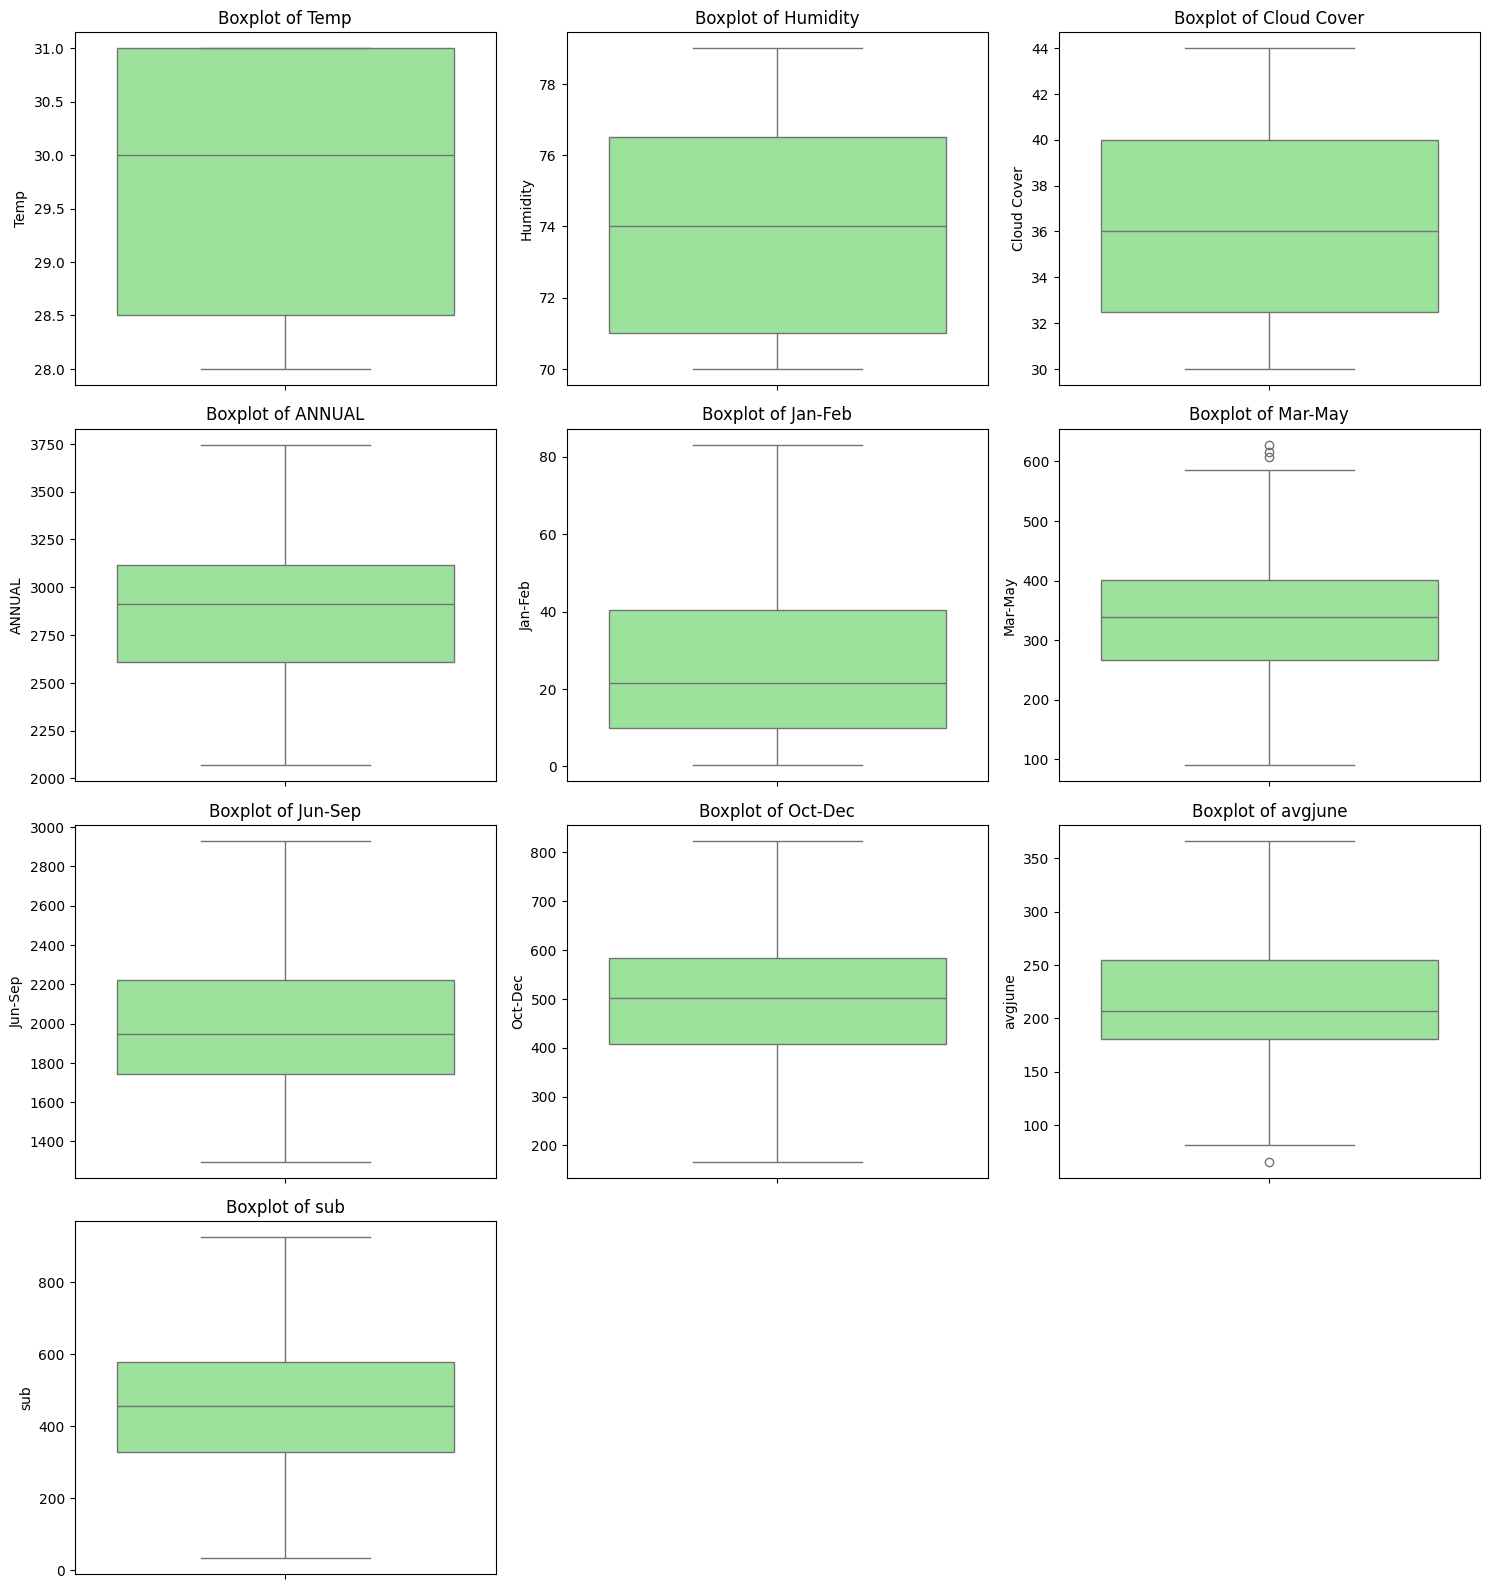

In [ ]:
# Boxplots post-removal
cols = 3
rows = (len(numerical_cols) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
axes = axes.flatten()
for i, col in enumerate(numerical_cols):
    sns.boxplot(y=df[col], ax=axes[i], color='lightgreen')
    axes[i].set_title(f'Boxplot of {col}')
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

In [ ]:
### 🧪 Model Training & Evaluation
X = df.drop('flood', axis=1)
y = df['flood'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Logistic Regression": LogisticRegression(C=1.0, solver='liblinear', random_state=42),
    "SVC": SVC(C=1.0, kernel='rbf', gamma='scale', random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, criterion='gini', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, criterion='gini', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'y_pred': y_pred
    }


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:55:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# 📊 Display evaluation results and confusion matrices
for name, res in results.items():
    print(f"\n🔹 {name}")
    print(f"Accuracy : {res['accuracy']:.4f}")
    print(f"Precision: {res['precision']:.4f}")
    print(f"Recall   : {res['recall']:.4f}")
    cm = confusion_matrix(y_test, res['y_pred'])
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()

In [ ]:
# 💾 Save best model (XGBoost) and scaler
xgb_model = models["XGBoost"]
dump((xgb_model, scaler), 'floods.save')
print("✅ Trained XGBoost model and scaler saved as 'floods.save'")